## Setup Paths and Configuration


In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Define paths
checkpoint_path = Path("/home/ubuntu/.cache/bionemo/a27061ee347f453b1bf175e288df31e9813903ebcb4924a77ac50dccc730889d-geneformer_10M_240530_nemo2.tar.gz.untar")
data_path = Path("/workspaces/bionemo-framework/sub-packages/bionemo-geneformer/src/bionemo/geneformer/test_data/scmemmap_processed_data/test")
results_path = Path("./geneformer_inference_results")

# Create results directory
results_path.mkdir(parents=True, exist_ok=True)

# Configuration
micro_batch_size = 64
seq_length = 2048
num_dataset_workers = 4
num_gpus = 1

print(f"Checkpoint: {checkpoint_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")
print(f"\nCheckpoint exists: {checkpoint_path.exists()}")
print(f"Data path exists: {data_path.exists()}")


Checkpoint: /home/ubuntu/.cache/bionemo/a27061ee347f453b1bf175e288df31e9813903ebcb4924a77ac50dccc730889d-geneformer_10M_240530_nemo2.tar.gz.untar
Data path: /workspaces/bionemo-framework/sub-packages/bionemo-geneformer/src/bionemo/geneformer/test_data/scmemmap_processed_data/test
Results path: geneformer_inference_results

Checkpoint exists: True
Data path exists: True


## Run Inference

We use the `infer_geneformer_scmap` command to run inference on the SCMAP test dataset.

This extracts embeddings from the standard geneformer model.

Key flags:
- `--include-embeddings`: Extract cell-level embeddings (enabled by default, use `--no-embeddings` to disable)
- `--include-hiddens`: Extract per-token hidden states (optional)
- `--include-input-ids`: Include input token IDs for mapping back to genes


In [2]:
!infer_geneformer_scmap \
    --data-dir {data_path} \
    --checkpoint-path {checkpoint_path} \
    --results-path {results_path} \
    --micro-batch-size {micro_batch_size} \
    --seq-length {seq_length} \
    --num-dataset-workers {num_dataset_workers} \
    --num-gpus {num_gpus} \
    --include-input-ids


/bin/bash: line 1: infer_geneformer_scmap: command not found


## Load Inference Results

The inference results are saved as a PyTorch `.pt` file containing:
- `embeddings`: Cell-level representations (N_cells x embedding_dim)
- `hidden_states`: Per-token hidden states (N_cells x seq_len x embedding_dim)
- `input_ids`: Token IDs for each cell
- `token_logits`: Output logits (if included)
- `binary_logits`: Binary classification logits (if applicable)


In [2]:
import torch
import numpy as np

# Load predictions
predictions_file = results_path / "predictions__rank_0.pt"
print(f"Loading predictions from: {predictions_file}")

predictions = torch.load(predictions_file, weights_only=False)

# Check what keys are available
print(f"\nAvailable keys: {predictions.keys()}")

# Extract embeddings
embeddings = predictions["embeddings"].float().cpu().numpy()
print(f"\nEmbeddings shape: {embeddings.shape}")
print(f"Number of cells: {embeddings.shape[0]}")
print(f"Embedding dimension: {embeddings.shape[1]}")


Loading predictions from: geneformer_inference_results/predictions__rank_0.pt

Available keys: dict_keys(['token_logits', 'binary_logits', 'input_ids', 'embeddings'])

Embeddings shape: (119157, 256)
Number of cells: 119157
Embedding dimension: 256


## Load Metadata and Dataset Labels

We'll load metadata to understand which dataset each cell belongs to and what cell type it is. This is useful for visualizing how well the model integrates different datasets and separates cell types.


In [3]:
import pandas as pd

# Load cell metadata from features.csv (SCMAP format)
# This file contains one row per cell with metadata like cell_type, tissue, assay, etc.
features_csv = data_path / "features.csv"

print(f"Loading cell metadata from: {features_csv}")
metadata = pd.read_csv(features_csv)

print(f"\nTotal cells in metadata: {len(metadata)}")
print(f"\nMetadata columns: {metadata.columns.tolist()}")
print(f"\nFirst few rows:")
print(metadata.head())

# Check for cell type distribution
if 'cell_type' in metadata.columns:
    print(f"\nCell type distribution (top 10):")
    print(metadata['cell_type'].value_counts().head(10))

# Check for dataset/assay distribution
if 'assay' in metadata.columns:
    print(f"\nAssay distribution:")
    print(metadata['assay'].value_counts())


Loading cell metadata from: /workspaces/bionemo-framework/sub-packages/bionemo-geneformer/src/bionemo/geneformer/test_data/scmemmap_processed_data/test/features.csv

Total cells in metadata: 119157

Metadata columns: ['tissue', 'is_primary_data', 'suspension_type', 'self_reported_ethnicity', 'disease', 'tissue_general', 'development_stage', 'cell_type', 'sex', 'assay']

First few rows:
  tissue  is_primary_data suspension_type self_reported_ethnicity disease  \
0  blood             True            cell                 unknown  normal   
1  blood             True            cell                 unknown  normal   
2  blood             True            cell                 unknown  normal   
3  blood             True            cell                 unknown  normal   
4  blood             True            cell                 unknown  normal   

  tissue_general  development_stage                        cell_type      sex  \
0          blood  human adult stage               classical monocyt

In [4]:
# Extract labels for visualization
# We'll create labels for both dataset and cell type

# Dataset labels (using assay as proxy for dataset)
if 'assay' in metadata.columns:
    dataset_labels = metadata['assay'].values
    print(f"Using assay for dataset visualization")
    print(f"Unique datasets: {metadata['assay'].nunique()}")
    print(f"\nDataset distribution:")
    print(metadata['assay'].value_counts())
elif 'tissue' in metadata.columns:
    dataset_labels = metadata['tissue'].values
    print(f"Using tissue for dataset visualization")
else:
    # Fallback: create synthetic labels
    n_cells = len(metadata)
    dataset_labels = np.array([f"Dataset {i%5}" for i in range(n_cells)])
    print("Created synthetic dataset labels")

# Cell type labels
if 'cell_type' in metadata.columns:
    celltype_labels = metadata['cell_type'].values
    print(f"\nUsing cell_type for cell type visualization")
    print(f"Unique cell types: {metadata['cell_type'].nunique()}")
else:
    celltype_labels = np.array(["Unknown"] * len(metadata))
    print("No cell_type column found")

# Ensure embeddings and labels have same length
print(f"\nEmbeddings shape: {embeddings.shape[0]}")
print(f"Dataset labels length: {len(dataset_labels)}")
print(f"Cell type labels length: {len(celltype_labels)}")
assert len(dataset_labels) == embeddings.shape[0], f"Mismatch! Embeddings: {embeddings.shape[0]}, Dataset labels: {len(dataset_labels)}"
assert len(celltype_labels) == embeddings.shape[0], f"Mismatch! Embeddings: {embeddings.shape[0]}, Cell type labels: {len(celltype_labels)}"


Using assay for dataset visualization
Unique datasets: 4

Dataset distribution:
assay
10x 5' transcription profiling    94726
10x 3' v3                         19639
10x 5' v1                          3968
10x 5' v2                           824
Name: count, dtype: int64

Using cell_type for cell type visualization
Unique cell types: 34

Embeddings shape: 119157
Dataset labels length: 119157
Cell type labels length: 119157


## Generate UMAP Projection

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that preserves both local and global structure. It's particularly effective for visualizing high-dimensional embeddings.

Key parameters:
- `n_neighbors`: Controls balance between local and global structure (15-50 typical)
- `min_dist`: Controls cluster tightness (0.0-0.5 typical)
- `metric`: Distance metric ('cosine' works well for embeddings)
- `n_components`: Number of dimensions to reduce to (2 for visualization)


In [5]:
import umap
from sklearn.preprocessing import StandardScaler

# Standardize embeddings (optional but often helpful)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

print("Computing UMAP projection...")
print("This may take a few minutes for large datasets...")

# Create UMAP reducer
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42,
    verbose=True
)

# Fit and transform
umap_embedding = reducer.fit_transform(embeddings_scaled)

print(f"\nUMAP embedding shape: {umap_embedding.shape}")
print(f"UMAP1 range: [{umap_embedding[:, 0].min():.2f}, {umap_embedding[:, 0].max():.2f}]")
print(f"UMAP2 range: [{umap_embedding[:, 1].min():.2f}, {umap_embedding[:, 1].max():.2f}]")


Computing UMAP projection...
This may take a few minutes for large datasets...
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Thu Oct 16 16:13:16 2025 Construct fuzzy simplicial set
Thu Oct 16 16:13:16 2025 Finding Nearest Neighbors
Thu Oct 16 16:13:16 2025 Building RP forest with 22 trees
Thu Oct 16 16:13:21 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Thu Oct 16 16:13:33 2025 Finished Nearest Neighbor Search
Thu Oct 16 16:13:34 2025 Construct embedding


Epochs completed:   2%| ▎          5/200 [00:00]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:03]

	completed  20  /  200 epochs


Epochs completed:  21%| ██         42/200 [00:06]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       63/200 [00:09]

	completed  60  /  200 epochs


Epochs completed:  41%| ████       82/200 [00:12]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     103/200 [00:15]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:18]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:21]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:24]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 183/200 [00:27]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:29]


Thu Oct 16 16:14:20 2025 Finished embedding

UMAP embedding shape: (119157, 2)
UMAP1 range: [-5.50, 21.79]
UMAP2 range: [-9.18, 15.35]


## Save UMAP Coordinates

Save the UMAP coordinates so you don't have to recompute them.


In [7]:
# Save UMAP coordinates
np.save(results_path / "umap_coordinates.npy", umap_embedding)
print(f"UMAP coordinates saved to {results_path / 'umap_coordinates.npy'}")

# Save metadata with UMAP coordinates
metadata_with_umap = metadata.copy()
metadata_with_umap['UMAP1'] = umap_embedding[:, 0]
metadata_with_umap['UMAP2'] = umap_embedding[:, 1]
metadata_with_umap['dataset_label'] = dataset_labels
metadata_with_umap['celltype_label'] = celltype_labels
metadata_with_umap.to_csv(results_path / "metadata_with_umap.csv", index=False)
print(f"Metadata with UMAP saved to {results_path / 'metadata_with_umap.csv'}")


UMAP coordinates saved to geneformer_inference_results/umap_coordinates.npy
Metadata with UMAP saved to geneformer_inference_results/metadata_with_umap.csv


## Visualize UMAP Projection - Colored by Dataset

Create a UMAP visualization showing how the geneformer model integrates different datasets in the latent space.


Number of unique datasets: 4
Datasets: ["10x 3' v3" "10x 5' transcription profiling" "10x 5' v1" "10x 5' v2"]



Figure saved to geneformer_inference_results/geneformer_umap_by_dataset.png


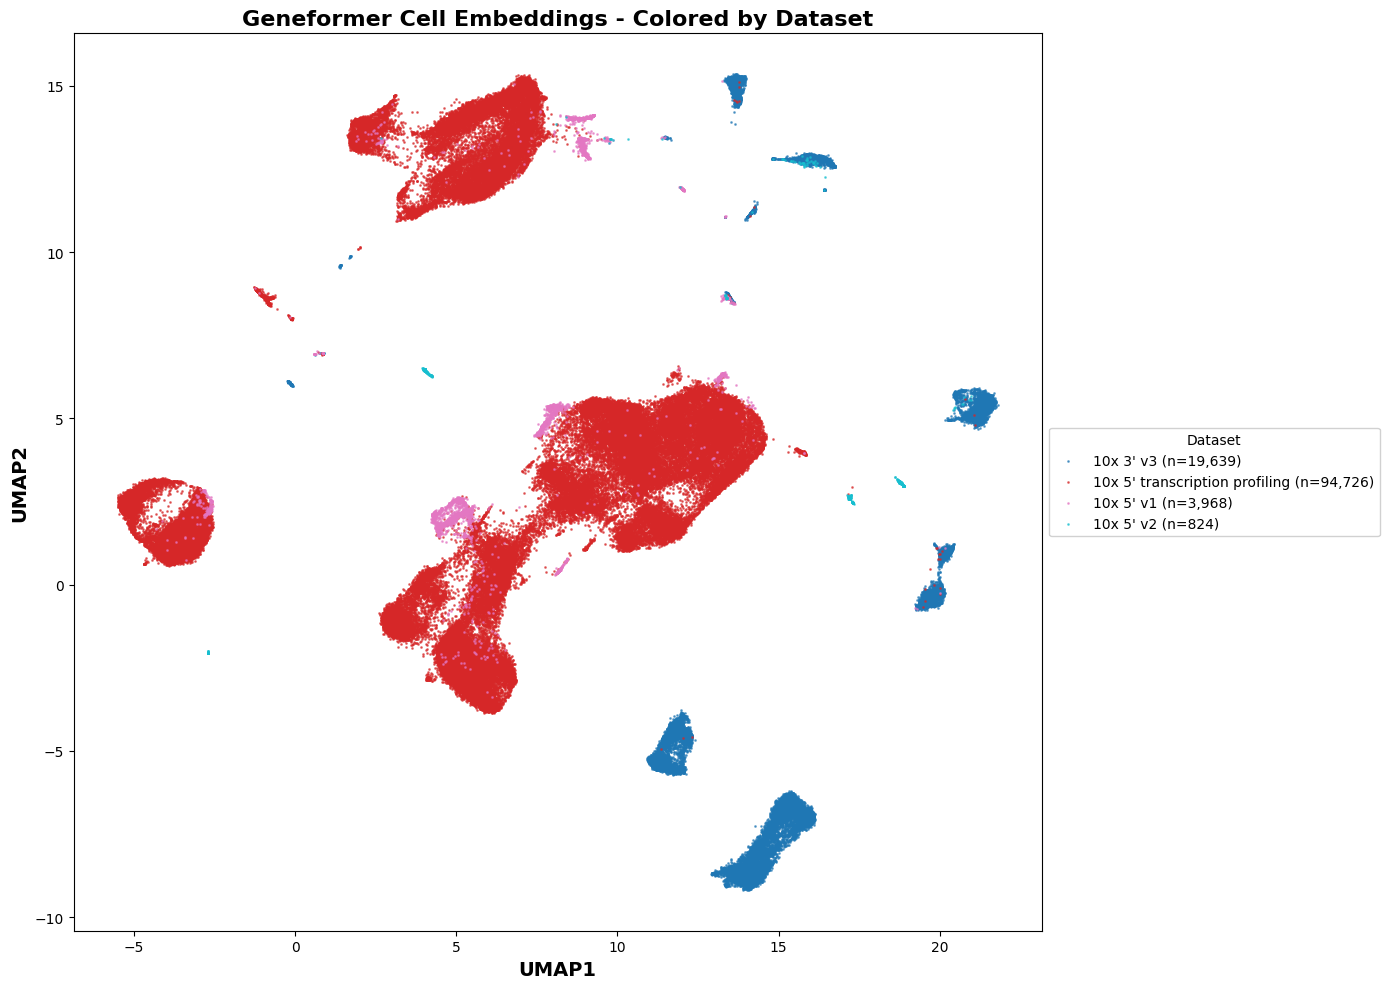

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
# sns.set_context("notebook", font_scale=1.2)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Get unique labels and assign colors
unique_datasets = np.unique(dataset_labels)
print(f"Number of unique datasets: {len(unique_datasets)}")
print(f"Datasets: {unique_datasets}")

# Use a colormap that can handle the number of categories
if len(unique_datasets) <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_datasets)))
elif len(unique_datasets) <= 20:
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_datasets)))
else:
    # For many labels, use continuous colormap
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_datasets)))

# Plot each dataset separately
for i, label in enumerate(unique_datasets):
    mask = dataset_labels == label
    n_cells = mask.sum()
    ax.scatter(
        umap_embedding[mask, 0],
        umap_embedding[mask, 1],
        c=[colors[i]],
        label=f"{label} (n={n_cells:,})",
        alpha=0.6,
        s=1,
        rasterized=True  # Better performance for many points
    )

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - Colored by Dataset', fontsize=16, fontweight='bold')

# Show legend if not too many labels
if len(unique_datasets) <= 15:
    ax.legend(title="Dataset", loc='center left', bbox_to_anchor=(1, 0.5), 
              frameon=True, fancybox=True, framealpha=0.9, fontsize=10)
else:
    print(f"Too many datasets ({len(unique_datasets)}) to show in legend")

# Add annotation
# ax.text(0.5, 1.02, f"UMAP projection of {embeddings.shape[0]:,} cell embeddings",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_by_dataset.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


## Visualize UMAP Projection - Colored by Source H5AD File

Create a UMAP visualization showing which original h5ad file each cell came from. This helps visualize batch effects or dataset integration.


In [7]:
import json

# Load metadata.json to get information about source files
metadata_json_path = data_path / "metadata.json"
print(f"Loading source file metadata from: {metadata_json_path}")

with open(metadata_json_path, 'r') as f:
    source_metadata = json.load(f)

# Create labels based on source file
# Each entry in metadata.json represents a source h5ad file
source_file_labels = []
source_file_names = []

for file_path, file_info in source_metadata.items():
    # Extract just the filename from the full path
    filename = file_path.split('/')[-1].replace('.h5ad', '')
    num_cells = file_info['shape'][0]
    
    print(f"Source file: {filename}")
    print(f"  Number of cells: {num_cells}")
    print(f"  Shape: {file_info['shape']}")
    
    # Create labels for all cells from this file
    source_file_labels.extend([filename] * num_cells)
    source_file_names.append(filename)
    print()

# Convert to numpy array
source_file_labels = np.array(source_file_labels)

print(f"Total cells labeled: {len(source_file_labels)}")
print(f"Number of source files: {len(source_file_names)}")
print(f"Source files: {source_file_names}")

# Verify it matches our embeddings
assert len(source_file_labels) == embeddings.shape[0], f"Mismatch! Embeddings: {embeddings.shape[0]}, Source labels: {len(source_file_labels)}"


Loading source file metadata from: /workspaces/bionemo-framework/sub-packages/bionemo-geneformer/src/bionemo/geneformer/test_data/scmemmap_processed_data/test/metadata.json
Source file: 01ad3cd7-3929-4654-84c0-6db05bd5fd59
  Number of cells: 94726
  Shape: [94726, 18140]

Source file: 1b9d8702-5af8-4142-85ed-020eb06ec4f6
  Number of cells: 24431
  Shape: [24431, 23974]

Total cells labeled: 119157
Number of source files: 2
Source files: ['01ad3cd7-3929-4654-84c0-6db05bd5fd59', '1b9d8702-5af8-4142-85ed-020eb06ec4f6']


Number of unique source files: 2

Figure saved to geneformer_inference_results/geneformer_umap_by_source_file.png


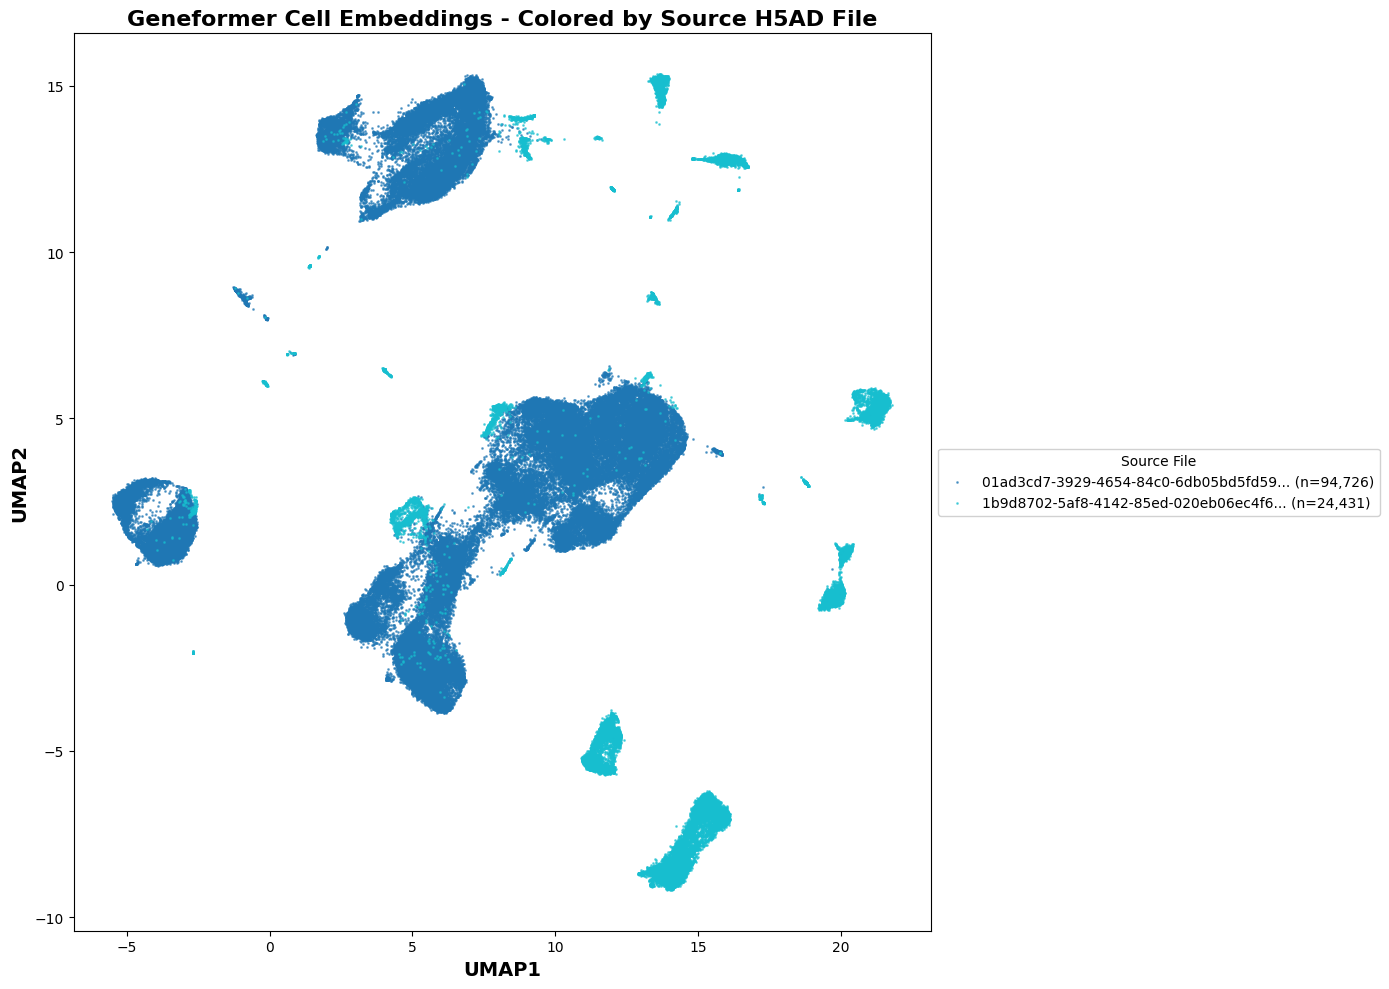

In [8]:
# Create figure for source file visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Get unique source files and assign colors
unique_sources = np.unique(source_file_labels)
print(f"Number of unique source files: {len(unique_sources)}")

# Use distinct colors for source files
if len(unique_sources) <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sources)))
else:
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_sources)))

# Plot each source file separately
for i, source in enumerate(unique_sources):
    mask = source_file_labels == source
    n_cells = mask.sum()
    ax.scatter(
        umap_embedding[mask, 0],
        umap_embedding[mask, 1],
        c=[colors[i]],
        label=f"{source[:40]}... (n={n_cells:,})",  # Truncate long filenames
        alpha=0.6,
        s=1,
        rasterized=True
    )

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - Colored by Source H5AD File', fontsize=16, fontweight='bold')

# Show legend
ax.legend(title="Source File", loc='center left', bbox_to_anchor=(1, 0.5), 
          frameon=True, fancybox=True, framealpha=0.9, fontsize=10)

# Add annotation
# ax.text(0.5, 1.02, f"UMAP projection of {embeddings.shape[0]:,} cells from {len(unique_sources)} source file(s)",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_by_source_file.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


## Visualize UMAP Projection - Colored by Cell Type

Create a UMAP visualization showing how the geneformer model separates different cell types in the latent space.


Number of unique cell types: 34
Cell types: ['B cell' 'CD16-negative, CD56-bright natural killer cell, human'
 'CD16-positive, CD56-dim natural killer cell, human'
 'CD4-positive helper T cell' 'CD4-positive, alpha-beta T cell'
 'CD8-positive, alpha-beta T cell'
 'CD8-positive, alpha-beta memory T cell'
 'CD8-positive, alpha-beta memory T cell, CD45RO-positive'
 'T follicular helper cell' 'alpha-beta T cell' 'alveolar macrophage'
 'animal cell' 'classical monocyte' 'conventional dendritic cell'
 'effector memory CD4-positive, alpha-beta T cell'
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated'
 'gamma-delta T cell' 'group 3 innate lymphoid cell' 'lymphocyte'
 'macrophage']...
Showing 34 cell types in legend with reduced font size

Figure saved to geneformer_inference_results/geneformer_umap_by_celltype.png


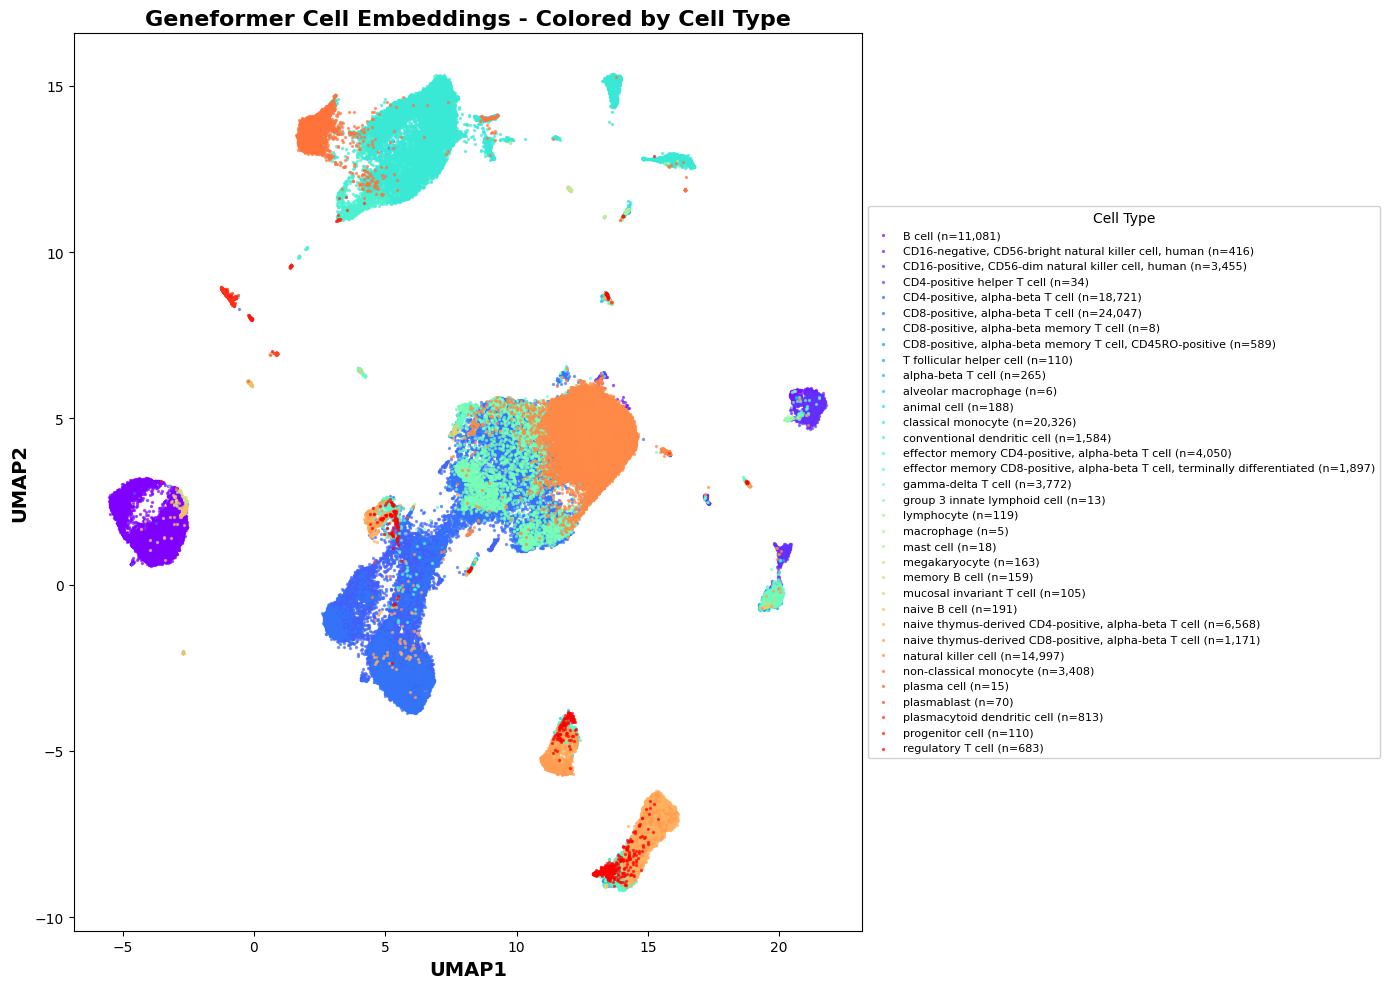

In [9]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Get unique cell types and assign colors
unique_celltypes = np.unique(celltype_labels)
print(f"Number of unique cell types: {len(unique_celltypes)}")
print(f"Cell types: {unique_celltypes[:20]}...")  # Show first 20

# Use a colormap that can handle many categories
if len(unique_celltypes) <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_celltypes)))
elif len(unique_celltypes) <= 20:
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_celltypes)))
else:
    # For many labels, use continuous colormap
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_celltypes)))

# Plot each cell type separately
for i, label in enumerate(unique_celltypes):
    mask = celltype_labels == label
    n_cells = mask.sum()
    ax.scatter(
        umap_embedding[mask, 0],
        umap_embedding[mask, 1],
        c=[colors[i]],
        label=f"{label} (n={n_cells:,})",
        alpha=0.6,
        s=2,
        rasterized=True  # Better performance for many points
    )

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - Colored by Cell Type', fontsize=16, fontweight='bold')

# # Only show legend if not too many labels
# if len(unique_celltypes) <= 15:
#     ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
#               frameon=True, fancybox=True, framealpha=0.9, fontsize=10)
# else:
#     print(f"Too many cell types ({len(unique_celltypes)}) to show in legend")

# Adjust legend based on number of cell types
if len(unique_celltypes) <= 15:
    ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
              frameon=True, fancybox=True, framealpha=0.9, fontsize=10)
else:
    # For many cell types, use smaller font and adjust layout
    ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
              frameon=True, fancybox=True, framealpha=0.9, fontsize=8,
              ncol=1)  # Use 2 columns for better space utilization
    print(f"Showing {len(unique_celltypes)} cell types in legend with reduced font size")

# Add annotation
# ax.text(0.5, 1.02, f"UMAP projection of {embeddings.shape[0]:,} cell embeddings",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_by_celltype.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


## Summary

This notebook performed standard inference on SCMAP data using the standard geneformer model.

### Key Points:
1. **Data**: SCMAP format from `/workspaces/bionemo-framework/sub-packages/bionemo-geneformer/src/bionemo/geneformer/test_data/scmemmap_processed_data/test`
2. **Model**: Standard geneformer checkpoint (10M parameters)
3. **Inference Mode**: Standard single-cell sequences `[CLS] gene1 gene2 ... [PAD]`
4. **Output**: Cell embeddings visualized via UMAP, colored by both dataset and cell type

### Visualizations:
- **UMAP by Dataset**: Shows how well the model integrates data from different experimental conditions/assays
- **UMAP by Cell Type**: Shows how well the model separates different cell types in the latent space

### Next Steps:
- Use embeddings for downstream tasks like clustering, classification, or trajectory inference
- Compare with embeddings from other models (e.g., temporal geneformer)
- Fine-tune the model on specific datasets or tasks


Highlighted: CD8-positive, alpha-beta T cell - 24,047 cells
Highlighted: effector memory CD8-positive, alpha-beta T cell, terminally differentiated - 1,897 cells
Highlighted: naive thymus-derived CD8-positive, alpha-beta T cell - 1,171 cells
Highlighted: CD8-positive, alpha-beta memory T cell, CD45RO-positive - 589 cells

Figure saved to geneformer_inference_results/geneformer_umap_highlighted_cd8_tcells.png


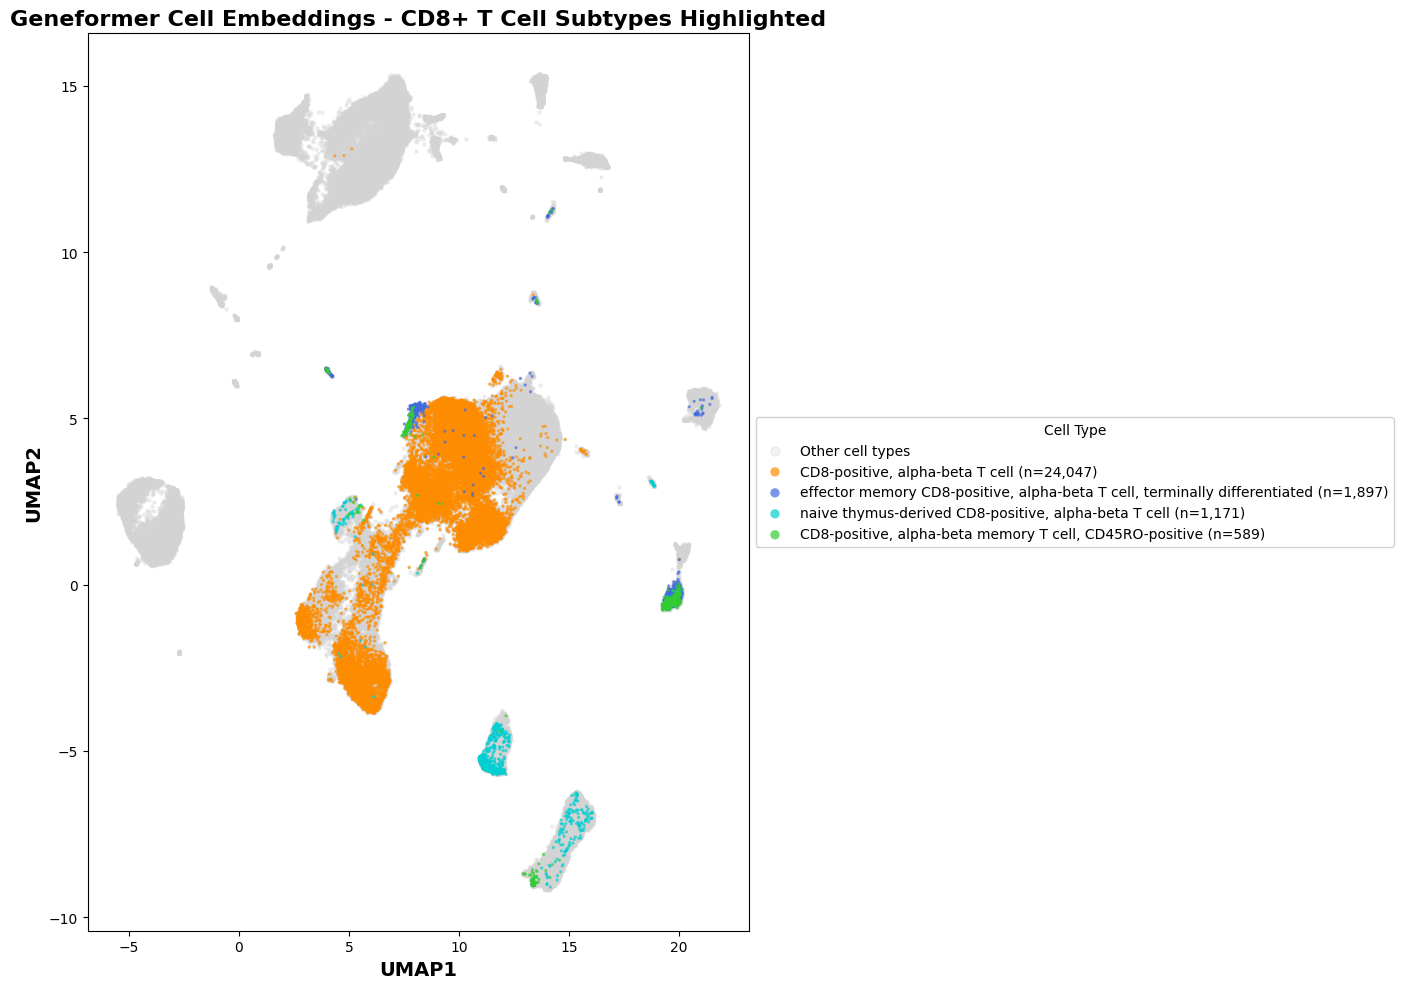

In [10]:
# Define the specific cell types to highlight
highlighted_cell_types = [
    'CD8-positive, alpha-beta T cell',
    'effector memory CD8-positive, alpha-beta T cell, terminally differentiated',
    'naive thymus-derived CD8-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta memory T cell, CD45RO-positive'
]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# First, plot all cells in gray (background)
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c='lightgray',
    alpha=0.3,
    s=5,
    rasterized=True,
    label='Other cell types'
)

# Define colors for the highlighted cell types (matching the image colors)
# Orange, Blue, Cyan, Green
highlight_colors = ['#FF8C00', '#4169E1', '#00CED1', '#32CD32']

# Plot each highlighted cell type on top
for i, cell_type in enumerate(highlighted_cell_types):
    mask = celltype_labels == cell_type
    n_cells = mask.sum()
    
    if n_cells > 0:
        ax.scatter(
            umap_embedding[mask, 0],
            umap_embedding[mask, 1],
            c=highlight_colors[i],
            label=f"{cell_type} (n={n_cells:,})",
            alpha=0.7,
            s=5,
            rasterized=True,
            edgecolors='none'
        )
        print(f"Highlighted: {cell_type} - {n_cells:,} cells")
    else:
        print(f"Warning: No cells found for '{cell_type}'")

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - CD8+ T Cell Subtypes Highlighted', 
             fontsize=16, fontweight='bold')

# Show legend with larger markers
ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
          frameon=True, fancybox=True, framealpha=0.9, fontsize=10, markerscale=3)

# # Add annotation
# total_highlighted = sum([np.sum(celltype_labels == ct) for ct in highlighted_cell_types])
# ax.text(0.5, 1.02, 
#         f"UMAP projection highlighting {total_highlighted:,} CD8+ T cells out of {embeddings.shape[0]:,} total cells",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_highlighted_cd8_tcells.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


Highlighted: CD8-positive, alpha-beta T cell - 24,047 cells
Highlighted: effector memory CD8-positive, alpha-beta T cell, terminally differentiated - 1,897 cells
Highlighted: naive thymus-derived CD8-positive, alpha-beta T cell - 1,171 cells
Highlighted: CD8-positive, alpha-beta memory T cell, CD45RO-positive - 589 cells



Figure saved to geneformer_inference_results/geneformer_umap_highlighted_cd8_tcells.png


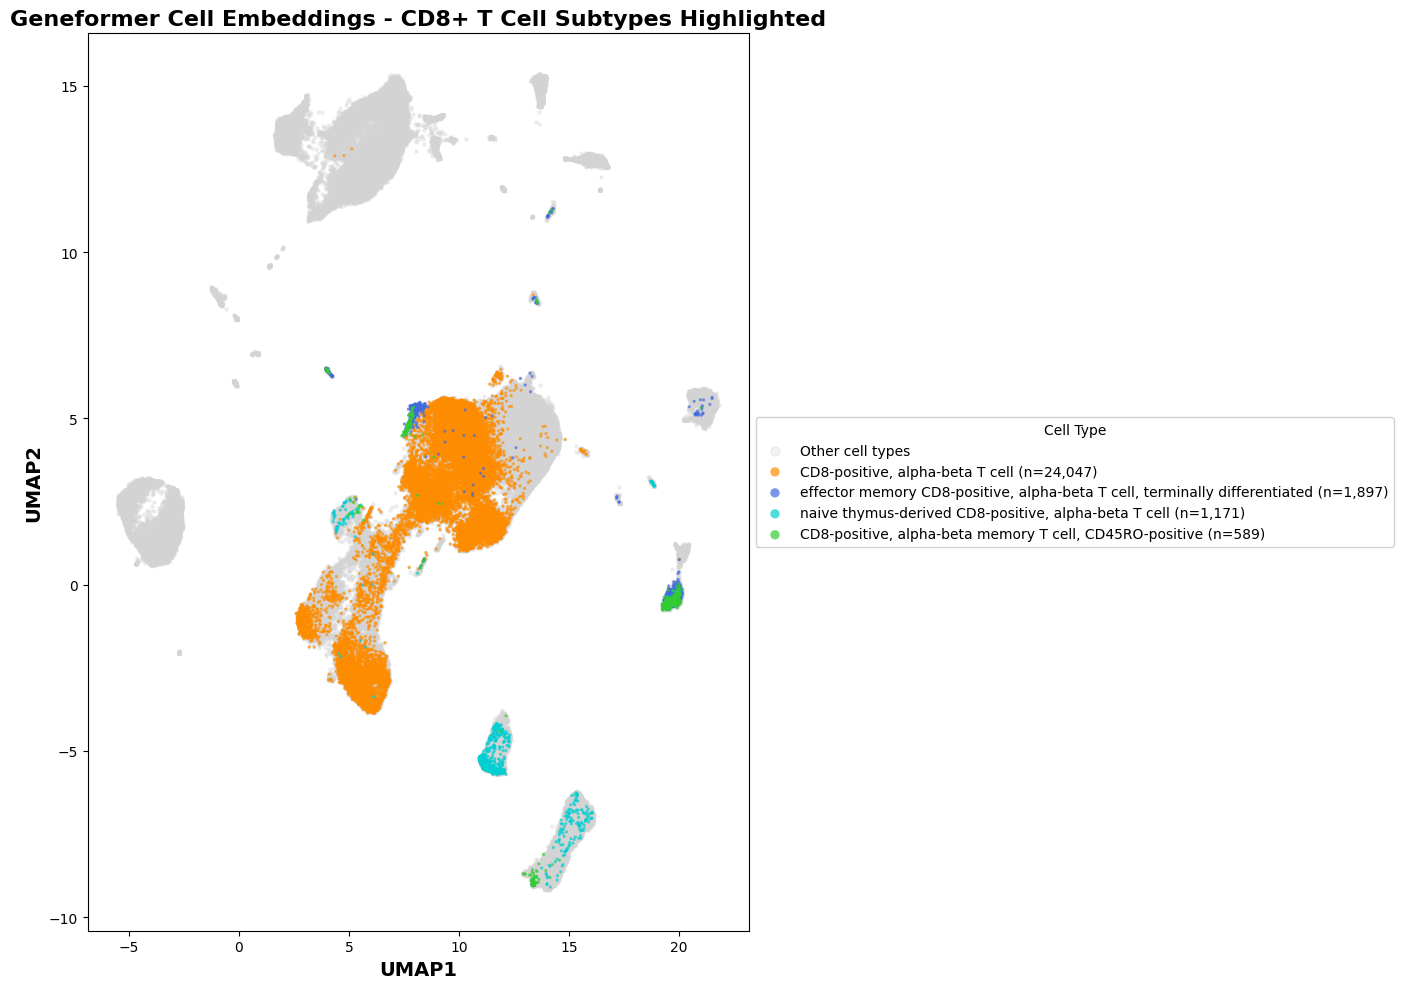

In [11]:
# Define the specific cell types to highlight
highlighted_cell_types = [
    'CD8-positive, alpha-beta T cell',
    'effector memory CD8-positive, alpha-beta T cell, terminally differentiated',
    'naive thymus-derived CD8-positive, alpha-beta T cell',
    'CD8-positive, alpha-beta memory T cell, CD45RO-positive'
]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# First, plot all cells in gray (background)
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c='lightgray',
    alpha=0.3,
    s=5,
    rasterized=True,
    label='Other cell types'
)

# Define colors for the highlighted cell types (matching the image colors)
# Orange, Blue, Cyan, Green
highlight_colors = ['#FF8C00', '#4169E1', '#00CED1', '#32CD32']

# Plot each highlighted cell type on top
for i, cell_type in enumerate(highlighted_cell_types):
    mask = celltype_labels == cell_type
    n_cells = mask.sum()
    
    if n_cells > 0:
        ax.scatter(
            umap_embedding[mask, 0],
            umap_embedding[mask, 1],
            c=highlight_colors[i],
            label=f"{cell_type} (n={n_cells:,})",
            alpha=0.7,
            s=5,
            rasterized=True,
            edgecolors='none'
        )
        print(f"Highlighted: {cell_type} - {n_cells:,} cells")
    else:
        print(f"Warning: No cells found for '{cell_type}'")

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - CD8+ T Cell Subtypes Highlighted', 
             fontsize=16, fontweight='bold')

# Show legend with larger markers
ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
          frameon=True, fancybox=True, framealpha=0.9, fontsize=10, markerscale=3)

# # Add annotation
# total_highlighted = sum([np.sum(celltype_labels == ct) for ct in highlighted_cell_types])
# ax.text(0.5, 1.02, 
#         f"UMAP projection highlighting {total_highlighted:,} CD8+ T cells out of {embeddings.shape[0]:,} total cells",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_highlighted_cd8_tcells.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


Highlighted: CD4-positive, alpha-beta T cell - 18,721 cells
Highlighted: naive thymus-derived CD4-positive, alpha-beta T cell - 6,568 cells
Highlighted: effector memory CD4-positive, alpha-beta T cell - 4,050 cells



Figure saved to geneformer_inference_results/geneformer_umap_highlighted_cd4_tcells.png


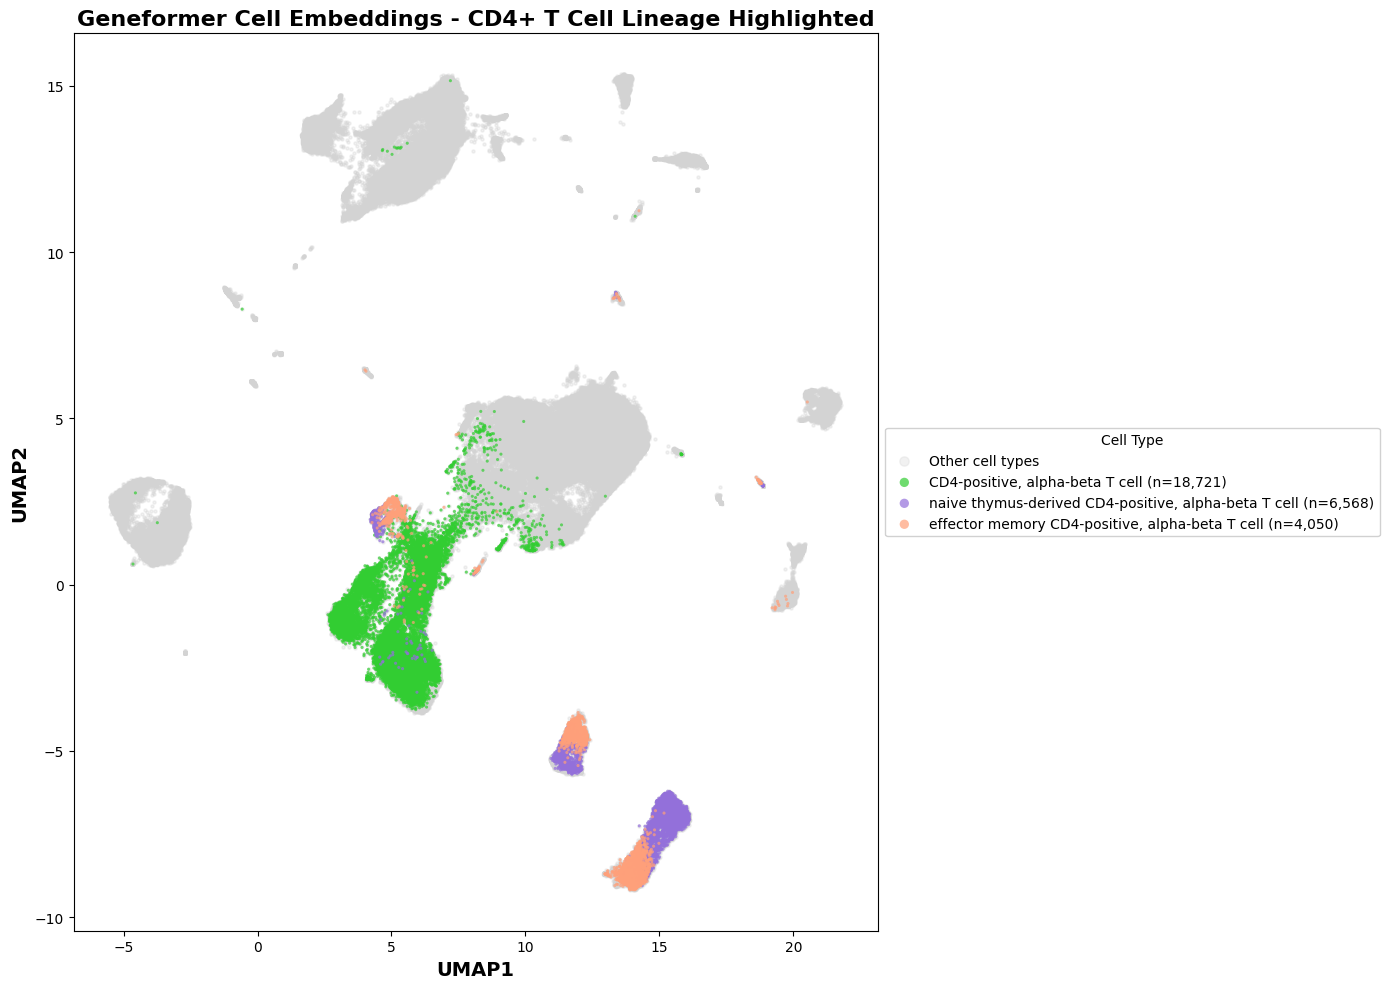

In [12]:
# Define the specific CD4+ cell types to highlight
highlighted_cd4_types = [
    'CD4-positive, alpha-beta T cell',
    'naive thymus-derived CD4-positive, alpha-beta T cell',
    'effector memory CD4-positive, alpha-beta T cell'
]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# First, plot all cells in gray (background)
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c='lightgray',
    alpha=0.3,
    s=5,
    rasterized=True,
    label='Other cell types'
)

# Define colors for the highlighted CD4+ cell types (matching the image colors)
# Green, Purple/Magenta, Light Pink/Salmon
cd4_colors = ['#32CD32', '#9370DB', '#FFA07A']

# Plot each highlighted cell type on top
for i, cell_type in enumerate(highlighted_cd4_types):
    mask = celltype_labels == cell_type
    n_cells = mask.sum()
    
    if n_cells > 0:
        ax.scatter(
            umap_embedding[mask, 0],
            umap_embedding[mask, 1],
            c=cd4_colors[i],
            label=f"{cell_type} (n={n_cells:,})",
            alpha=0.7,
            s=5,
            rasterized=True,
            edgecolors='none'
        )
        print(f"Highlighted: {cell_type} - {n_cells:,} cells")
    else:
        print(f"Warning: No cells found for '{cell_type}'")

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - CD4+ T Cell Lineage Highlighted', 
             fontsize=16, fontweight='bold')

# Show legend with larger markers
ax.legend(title="Cell Type", loc='center left', bbox_to_anchor=(1, 0.5), 
          frameon=True, fancybox=True, framealpha=0.9, fontsize=10, markerscale=3)

# Add annotation
# total_highlighted = sum([np.sum(celltype_labels == ct) for ct in highlighted_cd4_types])
# ax.text(0.5, 1.02, 
#         f"UMAP projection highlighting {total_highlighted:,} CD4+ T cells out of {embeddings.shape[0]:,} total cells",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_highlighted_cd4_tcells.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


Highlighted: naive B cell - 191 cells
Highlighted: B cell - 11,081 cells
Highlighted: memory B cell - 159 cells
Highlighted: plasmablast - 70 cells
Highlighted: plasma cell - 15 cells



Figure saved to geneformer_inference_results/geneformer_umap_b_cell_lineage.png


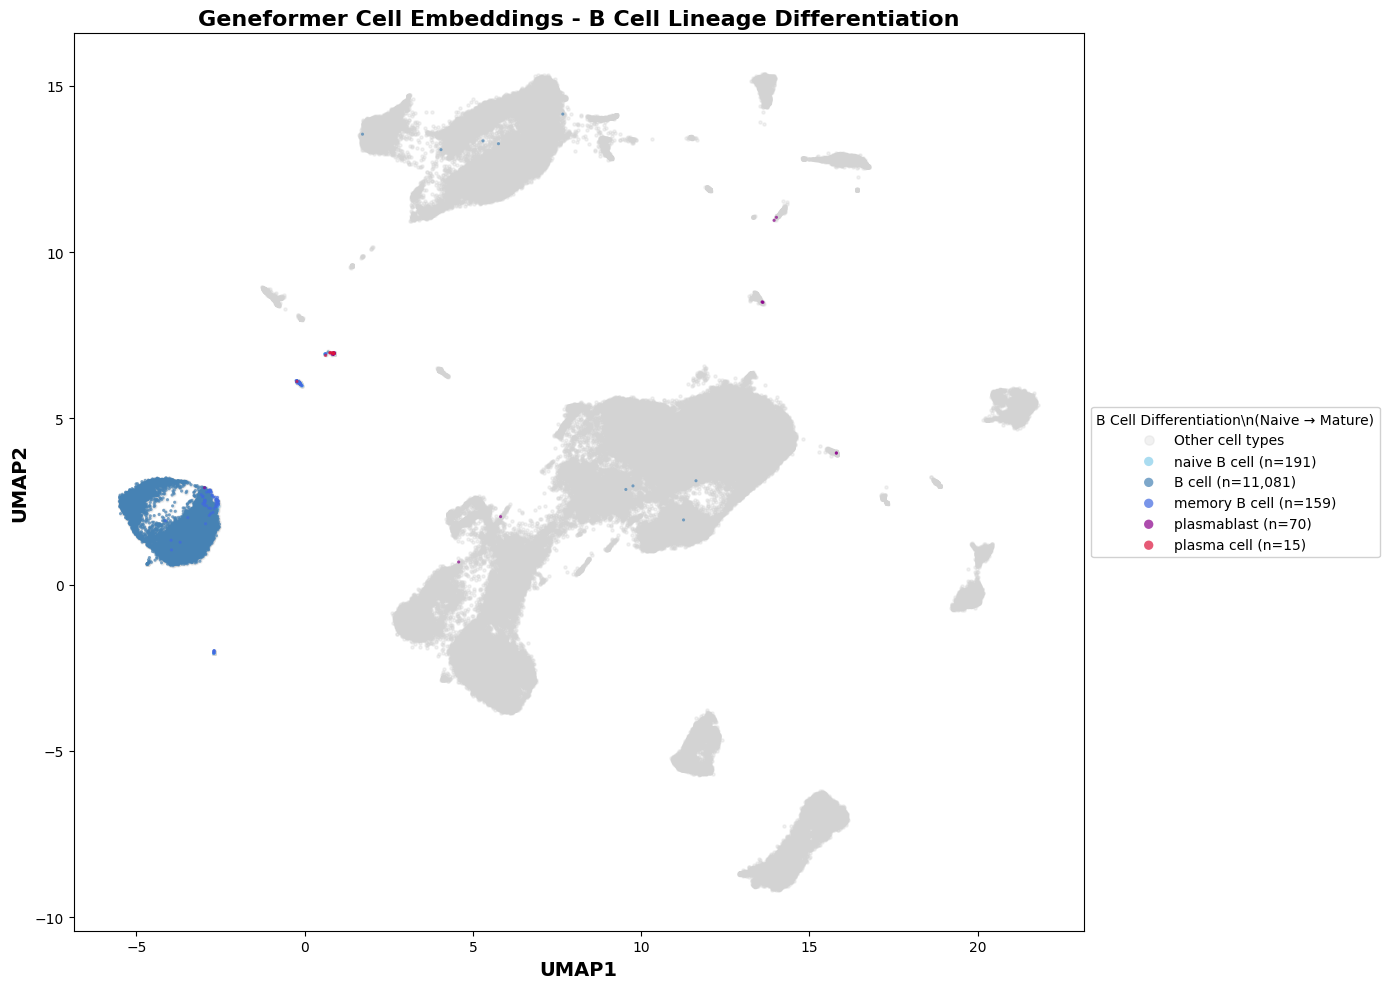

In [13]:
# Define the B cell lineage in order of differentiation (naive → mature)
b_cell_lineage = [
    'naive B cell',                    # Least differentiated - just from bone marrow
    'B cell',                          # General/activated B cells  
    'memory B cell',                   # Long-lived memory subset
    'plasmablast',                     # Pre-plasma cell, actively dividing
    'plasma cell'                      # Most differentiated - antibody-secreting
]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# First, plot all cells in gray (background)
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c='lightgray',
    alpha=0.3,
    s=5,
    rasterized=True,
    label='Other cell types'
)

# Define colors showing differentiation gradient (light → dark)
# Light to dark represents naive to mature differentiation
b_cell_colors = [
    '#87CEEB',  # Sky Blue - Naive B cell
    '#4682B4',  # Steel Blue - B cell (general)
    '#4169E1',  # Royal Blue - Memory B cell  
    '#8B008B',  # Dark Magenta - Plasmablast
    '#DC143C'   # Crimson - Plasma cell (most mature)
]

# Plot each B cell type on top
for i, cell_type in enumerate(b_cell_lineage):
    mask = celltype_labels == cell_type
    n_cells = mask.sum()
    
    if n_cells > 0:
        ax.scatter(
            umap_embedding[mask, 0],
            umap_embedding[mask, 1],
            c=b_cell_colors[i],
            label=f"{cell_type} (n={n_cells:,})",
            alpha=0.7,
            s=5,
            rasterized=True,
            edgecolors='none'
        )
        print(f"Highlighted: {cell_type} - {n_cells:,} cells")
    else:
        print(f"Warning: No cells found for '{cell_type}'")

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - B Cell Lineage Differentiation', 
             fontsize=16, fontweight='bold')

# Show legend with larger markers
ax.legend(title="B Cell Differentiation\\n(Naive → Mature)", loc='center left', 
          bbox_to_anchor=(1, 0.5), frameon=True, fancybox=True, 
          framealpha=0.9, fontsize=10, markerscale=3)

# Add annotation
# total_highlighted = sum([np.sum(celltype_labels == ct) for ct in b_cell_lineage])
# ax.text(0.5, 1.02, 
#         f"UMAP projection of B cell lineage: {total_highlighted:,} cells out of {embeddings.shape[0]:,} total cells",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_b_cell_lineage.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


Highlighted: naive B cell - 191 cells
Highlighted: memory B cell - 159 cells
Highlighted: plasmablast - 70 cells
Highlighted: plasma cell - 15 cells

Figure saved to geneformer_inference_results/geneformer_umap_b_cell_lineage.png


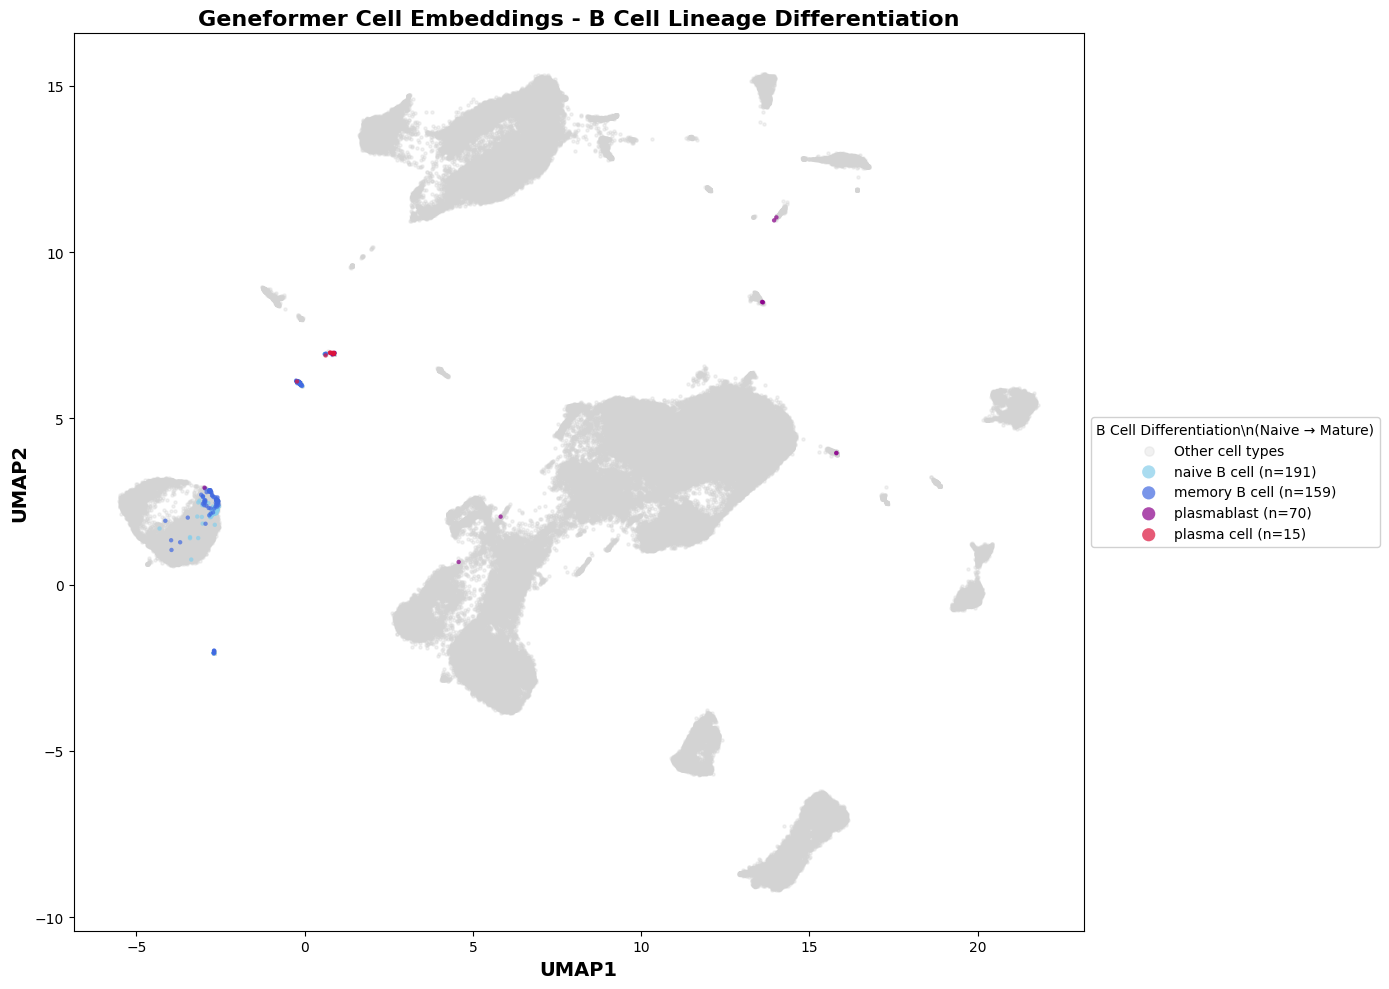

In [14]:
# Define the B cell lineage in order of differentiation (naive → mature)
b_cell_lineage = [
    'naive B cell',                    # Least differentiated - just from bone marrow
    'memory B cell',                   # Long-lived memory subset
    'plasmablast',                     # Pre-plasma cell, actively dividing
    'plasma cell'                      # Most differentiated - antibody-secreting
]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# First, plot all cells in gray (background)
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c='lightgray',
    alpha=0.3,
    s=5,
    rasterized=True,
    label='Other cell types'
)

# Define colors showing differentiation gradient (light → dark)
# Light to dark represents naive to mature differentiation
b_cell_colors = [
    '#87CEEB',  # Sky Blue - Naive B cell
    '#4169E1',  # Royal Blue - Memory B cell  
    '#8B008B',  # Dark Magenta - Plasmablast
    '#DC143C'   # Crimson - Plasma cell (most mature)
]

# Plot each B cell type on top
for i, cell_type in enumerate(b_cell_lineage):
    mask = celltype_labels == cell_type
    n_cells = mask.sum()
    
    if n_cells > 0:
        ax.scatter(
            umap_embedding[mask, 0],
            umap_embedding[mask, 1],
            c=b_cell_colors[i],
            label=f"{cell_type} (n={n_cells:,})",
            alpha=0.7,
            s=10,
            rasterized=True,
            edgecolors='none'
        )
        print(f"Highlighted: {cell_type} - {n_cells:,} cells")
    else:
        print(f"Warning: No cells found for '{cell_type}'")

# Formatting
ax.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax.set_title('Geneformer Cell Embeddings - B Cell Lineage Differentiation', 
             fontsize=16, fontweight='bold')

# Show legend with larger markers
ax.legend(title="B Cell Differentiation\\n(Naive → Mature)", loc='center left', 
          bbox_to_anchor=(1, 0.5), frameon=True, fancybox=True, 
          framealpha=0.9, fontsize=10, markerscale=3)

# Add annotation
# total_highlighted = sum([np.sum(celltype_labels == ct) for ct in b_cell_lineage])
# ax.text(0.5, 1.02, 
#         f"UMAP projection of B cell lineage: {total_highlighted:,} cells out of {embeddings.shape[0]:,} total cells",
#         ha='center', va='bottom', transform=ax.transAxes, fontsize=11, style='italic')

# Remove top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
output_file = results_path / "geneformer_umap_b_cell_lineage.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to {output_file}")

plt.show()


In [15]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
import time

print("=" * 80)
print("CLUSTERING QUALITY METRICS")
print("=" * 80)

# 1. SILHOUETTE SCORE - Measures separation of known cell types
print("\n1. SILHOUETTE SCORE (using known cell type labels)")
print("-" * 80)

# Compute silhouette score on UMAP embeddings using known cell types
silhouette_umap = silhouette_score(umap_embedding, celltype_labels, metric='euclidean')
print(f"Silhouette Score (UMAP space): {silhouette_umap:.4f}")

# Also compute on original embeddings for comparison
print("\nComputing silhouette on original embeddings (this may take a minute)...")
start_time = time.time()
silhouette_embeddings = silhouette_score(embeddings_scaled, celltype_labels, metric='euclidean')
elapsed = time.time() - start_time
print(f"Silhouette Score (original 256D embeddings): {silhouette_embeddings:.4f} (computed in {elapsed:.1f}s)")

print("\nInterpretation:")
print(f"  - UMAP preserves {(silhouette_umap/silhouette_embeddings)*100:.1f}% of the separation quality")
if silhouette_umap > 0.5:
    print(f"  - UMAP score of {silhouette_umap:.3f} indicates EXCELLENT cell type separation")
elif silhouette_umap > 0.3:
    print(f"  - UMAP score of {silhouette_umap:.3f} indicates GOOD cell type separation")
elif silhouette_umap > 0.1:
    print(f"  - UMAP score of {silhouette_umap:.3f} indicates MODERATE cell type separation")
else:
    print(f"  - UMAP score of {silhouette_umap:.3f} indicates WEAK cell type separation")

# 2. ADJUSTED RAND INDEX - Compare unsupervised clustering to known labels
print("\n\n2. ADJUSTED RAND INDEX (ARI)")
print("-" * 80)
print("Performing K-means clustering on UMAP to compare with known cell types...")

# Perform k-means clustering with the same number of clusters as cell types
n_celltypes = len(np.unique(np.array(celltype_labels)))
print(f"Number of known cell types: {n_celltypes}")
print("Running K-means clustering...")

kmeans = KMeans(n_clusters=n_celltypes, random_state=42, n_init='auto', max_iter=300)
predicted_clusters = kmeans.fit_predict(umap_embedding)

# Compute ARI
ari_score = adjusted_rand_score(celltype_labels, predicted_clusters)
print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")

print("\nInterpretation:")
if ari_score > 0.9:
    print(f"  - ARI of {ari_score:.3f} indicates EXCELLENT agreement - clustering recovers cell types nearly perfectly")
elif ari_score > 0.7:
    print(f"  - ARI of {ari_score:.3f} indicates GOOD agreement - clustering captures most cell type structure")
elif ari_score > 0.5:
    print(f"  - ARI of {ari_score:.3f} indicates MODERATE agreement - clustering partially recovers cell types")
elif ari_score > 0.3:
    print(f"  - ARI of {ari_score:.3f} indicates FAIR agreement - some cell type structure is captured")
else:
    print(f"  - ARI of {ari_score:.3f} indicates WEAK agreement - clustering doesn't match cell types well")

# Summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Silhouette Score (UMAP):    {silhouette_umap:.4f} - Measures known cell type separation")
print(f"Adjusted Rand Index (ARI):  {ari_score:.4f} - Measures clustering vs ground truth")
print("\nThese metrics quantify how well the Geneformer model has learned to:")
print("  1. Separate different cell types in latent space (Silhouette)")
print("  2. Enable unsupervised discovery of cell types (ARI)")
print("=" * 80)


CLUSTERING QUALITY METRICS

1. SILHOUETTE SCORE (using known cell type labels)
--------------------------------------------------------------------------------
Silhouette Score (UMAP space): 0.1257

Computing silhouette on original embeddings (this may take a minute)...
Silhouette Score (original 256D embeddings): 0.0841 (computed in 92.9s)

Interpretation:
  - UMAP preserves 149.5% of the separation quality
  - UMAP score of 0.126 indicates MODERATE cell type separation


2. ADJUSTED RAND INDEX (ARI)
--------------------------------------------------------------------------------
Performing K-means clustering on UMAP to compare with known cell types...
Number of known cell types: 34
Running K-means clustering...

Adjusted Rand Index (ARI): 0.3030

Interpretation:
  - ARI of 0.303 indicates FAIR agreement - some cell type structure is captured

SUMMARY
Silhouette Score (UMAP):    0.1257 - Measures known cell type separation
Adjusted Rand Index (ARI):  0.3030 - Measures clustering vs gr

In [16]:
from sklearn.metrics import silhouette_samples

# Compute per-sample silhouette scores
print("Computing per-cell silhouette scores...")
sample_silhouette_values = silhouette_samples(umap_embedding, celltype_labels)

# Calculate mean silhouette score for each cell type
unique_celltypes = np.unique(np.array(celltype_labels))
celltype_silhouette_scores = []

for celltype in unique_celltypes:
    mask = celltype_labels == celltype
    n_cells = mask.sum()
    mean_score = sample_silhouette_values[mask].mean()
    celltype_silhouette_scores.append({
        'cell_type': celltype,
        'n_cells': n_cells,
        'silhouette_score': mean_score
    })

# Create DataFrame and sort by silhouette score
celltype_scores_df = pd.DataFrame(celltype_silhouette_scores)
celltype_scores_df = celltype_scores_df.sort_values('silhouette_score', ascending=False)

print("\n" + "=" * 80)
print("PER-CELL-TYPE SILHOUETTE SCORES")
print("=" * 80)
print(f"\nOverall mean: {silhouette_umap:.4f}")
print(f"\nTop 10 best-separated cell types:")
print(celltype_scores_df.head(10).to_string(index=False))

print(f"\nBottom 10 least-separated cell types:")
print(celltype_scores_df.tail(10).to_string(index=False))

# Identify cell types with negative scores (poorly separated)
negative_scores = celltype_scores_df[celltype_scores_df['silhouette_score'] < 0]
if len(negative_scores) > 0:
    print(f"\n⚠️  Cell types with negative scores (overlapping with other types):")
    print(negative_scores.to_string(index=False))
else:
    print(f"\n✓ All cell types have positive silhouette scores!")


Computing per-cell silhouette scores...

PER-CELL-TYPE SILHOUETTE SCORES

Overall mean: 0.1257

Top 10 best-separated cell types:
                                            cell_type  n_cells  silhouette_score
                                           macrophage        5          0.889551
                                          plasma cell       15          0.870889
                                        megakaryocyte      163          0.767590
                          plasmacytoid dendritic cell      813          0.765119
                          conventional dendritic cell     1584          0.705393
                                               B cell    11081          0.587128
                               non-classical monocyte     3408          0.581779
                      CD4-positive, alpha-beta T cell    18721          0.575032
                                  natural killer cell    14997          0.532337
CD16-negative, CD56-bright natural killer cell, human      4

Figure saved to geneformer_inference_results/silhouette_scores_by_celltype.png


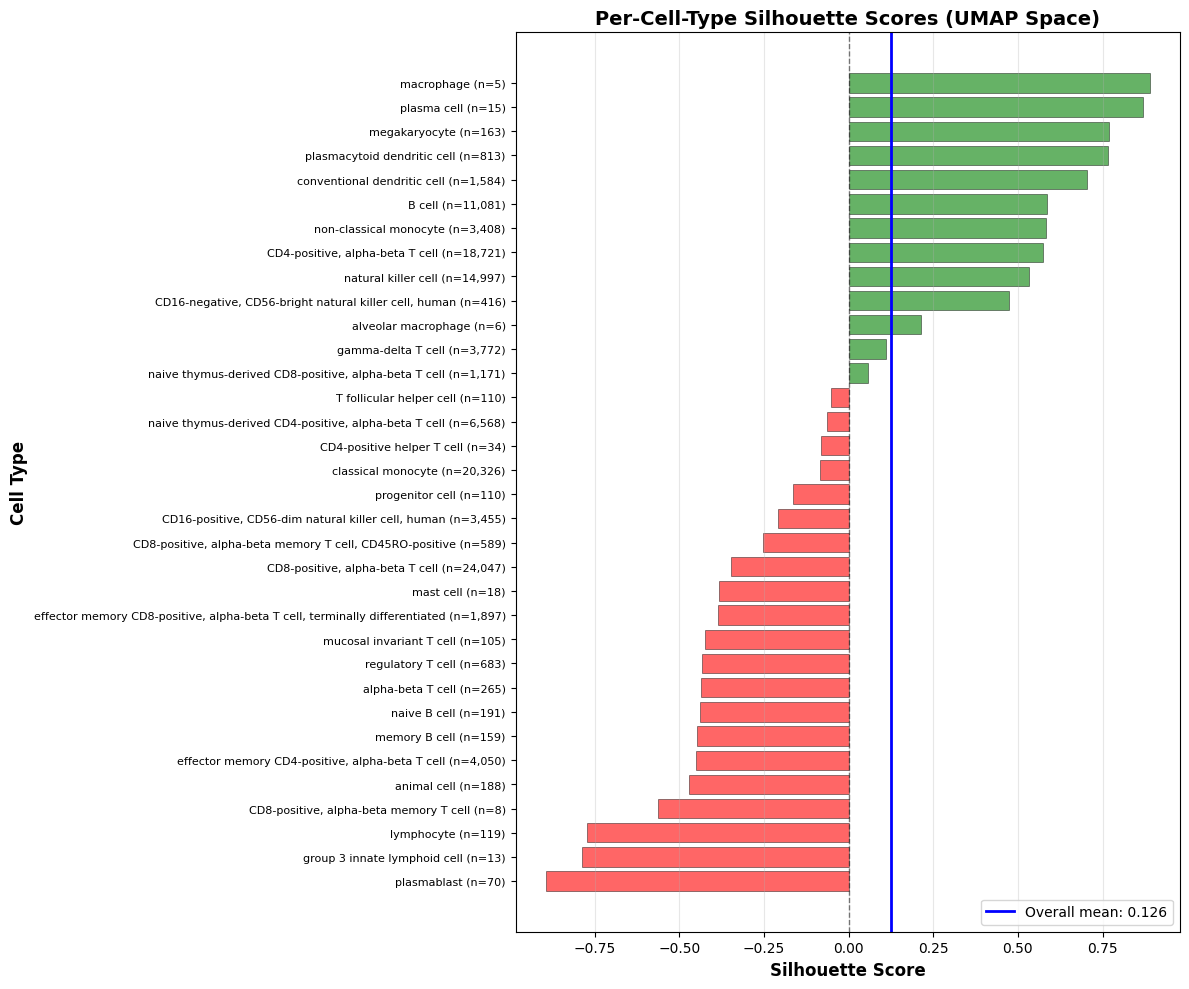

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Sort by score for better visualization
celltype_scores_df_sorted = celltype_scores_df.sort_values('silhouette_score')

# Create color map: negative = red, positive = green gradient
colors = ['red' if score < 0 else 'green' for score in celltype_scores_df_sorted['silhouette_score']]

# Create horizontal bar plot
bars = ax.barh(range(len(celltype_scores_df_sorted)), 
               celltype_scores_df_sorted['silhouette_score'],
               color=colors, alpha=0.6, edgecolor='black', linewidth=0.5)

# Set y-tick labels with cell counts
ax.set_yticks(range(len(celltype_scores_df_sorted)))
labels_with_counts = [f"{row['cell_type']} (n={row['n_cells']:,})" 
                      for _, row in celltype_scores_df_sorted.iterrows()]
ax.set_yticklabels(labels_with_counts, fontsize=8)

# Add vertical line at 0
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Add vertical line at overall mean
ax.axvline(x=silhouette_umap, color='blue', linestyle='-', linewidth=2, 
           label=f'Overall mean: {silhouette_umap:.3f}')

# Labels and title
ax.set_xlabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Cell Type', fontsize=12, fontweight='bold')
ax.set_title('Per-Cell-Type Silhouette Scores (UMAP Space)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

# Add grid
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
output_file = results_path / "silhouette_scores_by_celltype.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Figure saved to {output_file}")

plt.show()


In [19]:
# Filter the DataFrame for cell types with positive silhouette scores
positive_celltypes = celltype_scores_df[celltype_scores_df['silhouette_score'] > 0]['cell_type'].tolist()

# Print the list of cell types with positive silhouette scores
print("Cell types with positive silhouette scores:")
for cell_type in positive_celltypes:
    print(cell_type)


Cell types with positive silhouette scores:
macrophage
plasma cell
megakaryocyte
plasmacytoid dendritic cell
conventional dendritic cell
B cell
non-classical monocyte
CD4-positive, alpha-beta T cell
natural killer cell
CD16-negative, CD56-bright natural killer cell, human
alveolar macrophage
gamma-delta T cell
naive thymus-derived CD8-positive, alpha-beta T cell


Figure saved to geneformer_inference_results/kmeans_vs_ground_truth.png


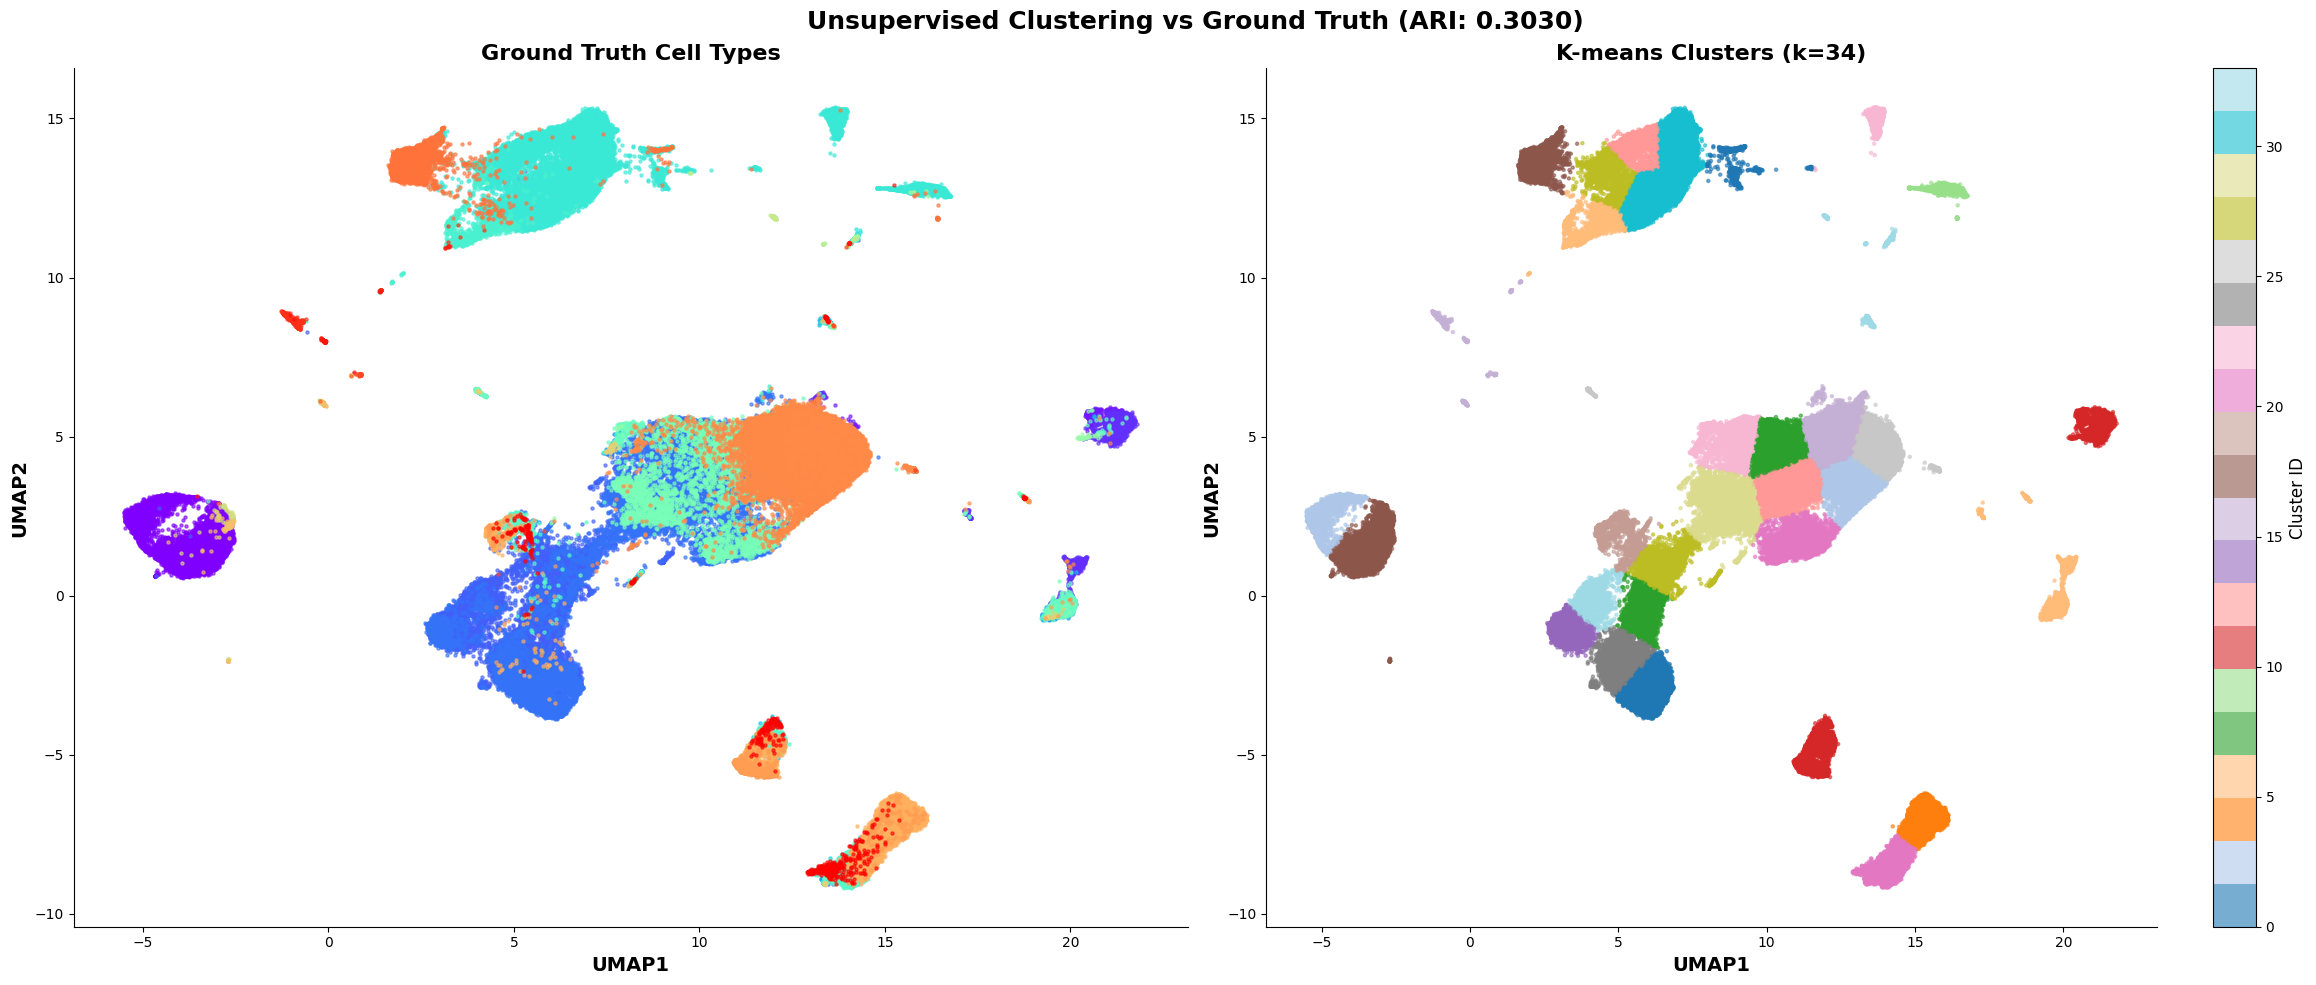

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Create proper color palette for all cell types
n_celltypes_plot = len(unique_celltypes)
if n_celltypes_plot <= 10:
    celltype_colors = plt.cm.tab10(np.linspace(0, 1, n_celltypes_plot))
elif n_celltypes_plot <= 20:
    celltype_colors = plt.cm.tab20(np.linspace(0, 1, n_celltypes_plot))
else:
    # For many cell types, use a continuous colormap
    celltype_colors = plt.cm.rainbow(np.linspace(0, 1, n_celltypes_plot))

# Left plot: Ground truth cell types
ax1 = axes[0]
for i, label in enumerate(unique_celltypes):
    mask = celltype_labels == label
    n_cells = mask.sum()
    ax1.scatter(
        umap_embedding[mask, 0],
        umap_embedding[mask, 1],
        c=[celltype_colors[i]],
        label=f"{label}",
        alpha=0.6,
        s=5,
        rasterized=True
    )

ax1.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax1.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax1.set_title('Ground Truth Cell Types', fontsize=16, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right plot: K-means clusters
ax2 = axes[1]
scatter = ax2.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=predicted_clusters,
    cmap='tab20',
    alpha=0.6,
    s=5,
    rasterized=True
)

ax2.set_xlabel('UMAP1', fontsize=14, fontweight='bold')
ax2.set_ylabel('UMAP2', fontsize=14, fontweight='bold')
ax2.set_title(f'K-means Clusters (k={n_celltypes})', fontsize=16, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add colorbar for k-means clusters
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', fontsize=12)

# Add overall title with ARI score
fig.suptitle(f'Unsupervised Clustering vs Ground Truth (ARI: {ari_score:.4f})', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()

# Save figure
output_file = results_path / "kmeans_vs_ground_truth.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Figure saved to {output_file}")

plt.show()
